### Import lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Import phishing_site_urls dataset

In [2]:
all_df = pd.read_csv(r'phishing_site_urls.csv')
# filtering to allow the label "good" and "bad" to be equal in #. 
bad_df = all_df[all_df['Label']=='bad']
good_df = all_df[all_df['Label']=='good']
#bad_df.info()
#good_df.info()
all_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [3]:
# Dropping last n rows using drop
remove_n = 236502
good_df = good_df.drop(good_df.tail(n = remove_n).index)
good_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 156422 entries, 18231 to 247092
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     156422 non-null  object
 1   Label   156422 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [4]:
bad_df.sample(10)

,URL,Label
25116,hbythhtyggrfr.ias3.com/hg/index.html,bad
1804,banulong.com/files/files/free.fr/reactiver/S/s...,bad
535279,clempurry.net/5du88,bad
548074,91.239.24.48:6892,bad
135648,vaginismusmd.com/?a=/,bad
530291,moroem.com/n79lv,bad
523856,panelreturn.tld.cc/dn/panel.php?m=login,bad
4323,www.acatel.pt/images/index.htm?dispatch=5885d8...,bad
538910,checkimage.comuf.com/076wc,bad
101454,iperso-mobillfree.com/moncompte/recouvrement_f...,bad


In [5]:
# merge database
urls_df = pd.concat([bad_df,good_df], axis=0)
#all_good = list(set(good_df))
#all_bad = list(set(bad_df))
# storing it in a dataframe
#urls_df = pd.merge(all_good, all_bad, how='outer')
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312844 entries, 0 to 247092
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     312844 non-null  object
 1   Label   312844 non-null  object
dtypes: object(2)
memory usage: 7.2+ MB


In [6]:
urls_df.tail()

,URL,Label
247088,thepinkstilettos.blogspot.com/,good
247089,thepinoy.net/?p=1320,good
247090,thepioneerwoman.com/cooking/2008/08/cooking-wi...,good
247091,thepioneerwoman.com/cooking/2008/09/cooking-wi...,good
247092,thepipelineshow.blogspot.com/2011/06/head-to-h...,good


In [7]:
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312844 entries, 0 to 247092
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     312844 non-null  object
 1   Label   312844 non-null  object
dtypes: object(2)
memory usage: 7.2+ MB


In [8]:
urls_df.isnull().sum()

URL      0
Label    0
dtype: int64

In [9]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [10]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

bad     156422
good    156422
Name: Label, dtype: int64


### Preprocessing

In [11]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
urls_df.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [12]:
tokenizer.tokenize(urls_df.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [13]:
urls_df['text_tokenized'] = urls_df.URL.parallel_map(lambda t: tokenizer.tokenize(t))

/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [14]:
urls_df.sample(5)

,URL,Label,text_tokenized
172455,en.wikipedia.org/wiki/Category:African_America...,good,"[en, wikipedia, org, wiki, Category, African, ..."
39318,paypal-note.de/login/4922/index.php,bad,"[paypal, note, de, login, index, php]"
82593,www.secondpicture.com/3d_tutorials.html,good,"[www, secondpicture, com, d, tutorials, html]"
85564,www.theregister.co.uk/2003/06/15/transmeta_exp...,good,"[www, theregister, co, uk, transmeta, exports,..."
496299,iminlife.com/cqoanbzr,bad,"[iminlife, com, cqoanbzr]"


In [15]:
stemmer = SnowballStemmer("english")
urls_df['text_stemmed'] = urls_df['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])


/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [16]:
urls_df.sample(5)

,URL,Label,text_tokenized,text_stemmed
75225,www.cmlab.csie.ntu.edu.tw/~robin/JavaGL/,good,"[www, cmlab, csie, ntu, edu, tw, robin, JavaGL]","[www, cmlab, csie, ntu, edu, tw, robin, javagl]"
180517,en.wikipedia.org/wiki/Shaun_Smith_(defensive_l...,good,"[en, wikipedia, org, wiki, Shaun, Smith, defen...","[en, wikipedia, org, wiki, shaun, smith, defen..."
67026,tools.ietf.org/html/rfc1030,good,"[tools, ietf, org, html, rfc]","[tool, ietf, org, html, rfc]"
236026,royalsociety.org/about-us/fellowship/,good,"[royalsociety, org, about, us, fellowship]","[royalsocieti, org, about, us, fellowship]"
518869,nursery.ds.ac.th/modules/mod_ariimageslidersa/...,bad,"[nursery, ds, ac, th, modules, mod, ariimagesl...","[nurseri, ds, ac, th, modul, mod, ariimageslid..."


In [17]:
urls_df['text_sent'] = urls_df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

/home/alex/.local/lib/python3.10/site-packages/pandarallel/data_types/series.py:42: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [18]:
urls_df.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
197949,homepages.rootsweb.ancestry.com/~maryc/renf192...,good,"[homepages, rootsweb, ancestry, com, maryc, re...","[homepag, rootsweb, ancestri, com, maryc, renf...",homepag rootsweb ancestri com maryc renf htm
133052,lafirmalegal.com/wp-includes/images/yoh/yaho/b...,bad,"[lafirmalegal, com, wp, includes, images, yoh,...","[lafirmaleg, com, wp, includ, imag, yoh, yaho,...",lafirmaleg com wp includ imag yoh yaho byte in...
157772,chemistrydaily.com/chemistry/chemistrydaily.co...,good,"[chemistrydaily, com, chemistry, chemistrydail...","[chemistrydaili, com, chemistri, chemistrydail...",chemistrydaili com chemistri chemistrydaili co...
485864,wordpress.mst-technology.de/wp-content/themes/...,bad,"[wordpress, mst, technology, de, wp, content, ...","[wordpress, mst, technolog, de, wp, content, t...",wordpress mst technolog de wp content theme te...
241887,sports.yahoo.com/mlb/players/8913,good,"[sports, yahoo, com, mlb, players]","[sport, yahoo, com, mlb, player]",sport yahoo com mlb player


### Visualization

In [19]:
bad_sites = urls_df[urls_df.Label == 'bad']
good_sites = urls_df[urls_df.Label == 'good']

In [20]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [21]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


### Creating Model

In [22]:
cv = CountVectorizer()
feature = cv.fit_transform(urls_df.text_sent)

In [23]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
trainX, testX, trainY, testY = train_test_split(feature, urls_df.Label)

### Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9574484407564153

In [26]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9799346213022039
Testing Accuracy : 0.9574484407564153

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.95      0.97      0.96     38428
        Good       0.97      0.95      0.96     39783

    accuracy                           0.96     78211
   macro avg       0.96      0.96      0.96     78211
weighted avg       0.96      0.96      0.96     78211


CONFUSION MATRIX


<AxesSubplot: >

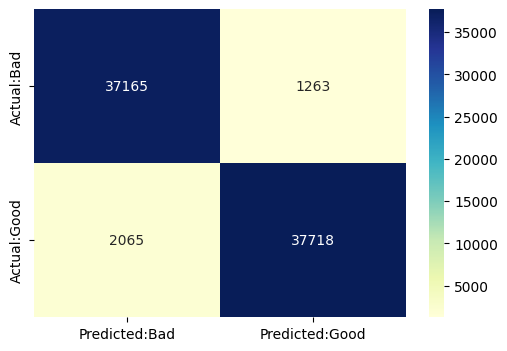

In [27]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Multinomial Naive Bayes

In [28]:
mnb = MultinomialNB()
mnb.fit(trainX,trainY)
mnb.score(testX,testY)

0.9486261523315135

In [29]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9680266629161286
Testing Accuracy : 0.9486261523315135

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.93      0.96      0.95     38148
        Good       0.96      0.94      0.95     40063

    accuracy                           0.95     78211
   macro avg       0.95      0.95      0.95     78211
weighted avg       0.95      0.95      0.95     78211


CONFUSION MATRIX


<AxesSubplot: >

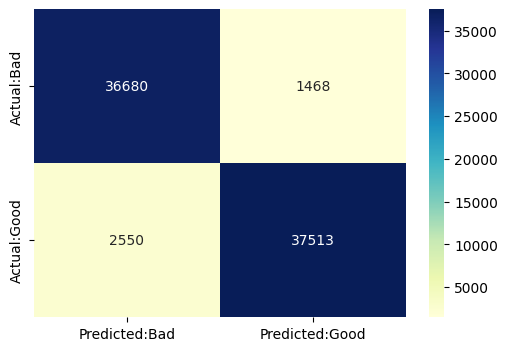

In [30]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Support Vector Machine

In [31]:
X_train, X_test, y_train, y_test = train_test_split(feature, urls_df.Label, test_size=0.25, random_state=27)


In [32]:
SVC_model = svm.SVC(kernel='linear')

In [33]:
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [34]:
SVC_prediction = SVC_model.predict(X_test)

In [35]:
print(confusion_matrix(SVC_prediction, y_test))

[[37940  1026]
 [ 1412 37833]]


### KNN_model

In [36]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

KNN_model.fit(X_train, y_train)

KNN_prediction = KNN_model.predict(X_test)
print(classification_report(KNN_prediction, y_test))

              precision    recall  f1-score   support

         bad       0.97      0.79      0.87     48277
        good       0.74      0.96      0.84     29934

    accuracy                           0.86     78211
   macro avg       0.86      0.88      0.86     78211
weighted avg       0.88      0.86      0.86     78211



Logistic Regression    0.96
MultinomialNB          0.95
Name: Accuracy, dtype: float64


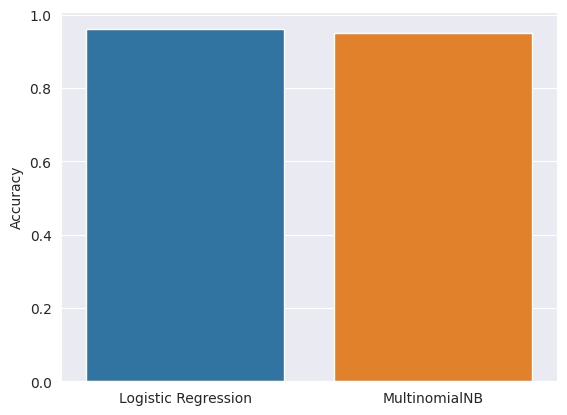

In [37]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(x=acc.index,y=acc.Accuracy)
print(acc.Accuracy)

### sklearn pipeline with Logistic Regression

In [38]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [39]:
trainX, testX, trainY, testY = train_test_split(urls_df.URL, urls_df.Label)

In [40]:
pipeline_ls.fit(trainX,trainY)

/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [41]:
pipeline_ls.score(testX,testY) 

0.9593151858434236

Training Accuracy : 0.9809574953224823
Testing Accuracy : 0.9593151858434236

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.95      0.97      0.96     38417
        Good       0.97      0.95      0.96     39794

    accuracy                           0.96     78211
   macro avg       0.96      0.96      0.96     78211
weighted avg       0.96      0.96      0.96     78211


CONFUSION MATRIX


<AxesSubplot: >

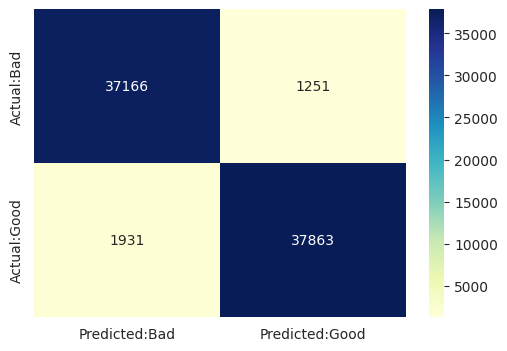

In [42]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [43]:
pickle.dump(pipeline_ls,open('phishing_equal_LR.pkl','wb'))
loaded_model = pickle.load(open('phishing_equal_LR.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9593151858434236


In [44]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_equal_LR.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']


# Test SVC model

[[37940  1026]
 [ 1412 37833]]
0.9688279142320134
Training Accuracy : 0.9969995695405165
Testing Accuracy : 0.968418764623902

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.96      0.97      0.97     38858
        Good       0.97      0.96      0.97     39353

    accuracy                           0.97     78211
   macro avg       0.97      0.97      0.97     78211
weighted avg       0.97      0.97      0.97     78211


CONFUSION MATRIX
0.968418764623902


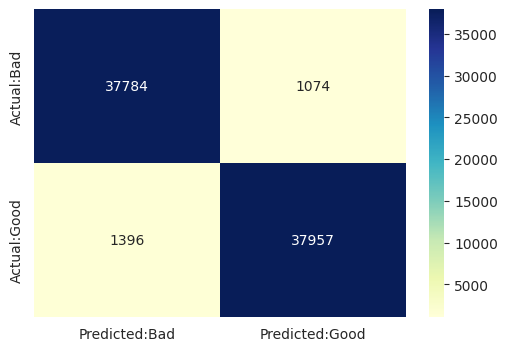

In [45]:
# Support Vector Machine
from sklearn import svm
SVC_model = svm.SVC(kernel='linear')
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)
# But Confusion Matrix and Classification Report give more details about performance
print(confusion_matrix(SVC_prediction, y_test))
# Accuracy score is the simplest way to evaluate
print(accuracy_score(SVC_prediction, y_test))

# sklearn pipeline using SVC
from sklearn.pipeline import make_pipeline
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), svm.SVC(kernel='linear'))
X_train, X_test, y_train, y_test = train_test_split(urls_df.URL, urls_df.Label)
pipeline_ls.fit(X_train,y_train)
pipeline_ls.score(X_test, y_test)

print('Training Accuracy :',pipeline_ls.score(X_train,y_train))
print('Testing Accuracy :',pipeline_ls.score(X_test,y_test))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(X_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(X_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

import pickle
pickle.dump(pipeline_ls,open('phishing_equal_SVC.pkl','wb'))
loaded_model = pickle.load(open('phishing_equal_SVC.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

In [46]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_equal_SVC.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
